## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
import numpy as np
from datasets import load_from_disk

from data import plot_examples, split_dataset, transform_to_tensor, transform_crop_and_resize, transform_res_net_18, transform_mnasnet_0_75, plt, transform_3_channels
from model import PneumoniaDetectionResNet18Model, PneumoniaDetectionMobileNetV3LargeModel, PneumoniaDetectionMNASNet0_75Model
from trainer import Trainer
from eval import evaluate_training, evaluate_test, plot_loss
from datetime import datetime

/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

allow_restnet18_training = False
resnet18_model_path = "checkpoints/2023_12_06_PneumoniaDetectionResNet18Model.pth"

allow_mobile_v3_large_training = False
mobile_v3_large_model_path = "checkpoints/2023_12_06_PneumoniaDetectionMobileNetV3LargeModel.pth"

allow_mnasnet_0_75_training = False
mnasnet_0_75_model_path = "checkpoints/2023_12_06_PneumoniaDetectionMNASNet0_75Model.pth"

allow_testing = False
nih_test_dataset_path = "data/nih_test_dataset/"

## 2. Dataset

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [3]:
train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
validation_set = torchvision.datasets.ImageFolder(root="data/val", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
merged_dataset = ConcatDataset([train_set, validation_set])
train_set, validation_set = split_dataset(merged_dataset, 0.7)

classes = merged_dataset.datasets[0].classes
print(f"Classes: {classes}")

Classes: ['NORMAL', 'PNEUMONIA']


<Figure size 1200x700 with 0 Axes>

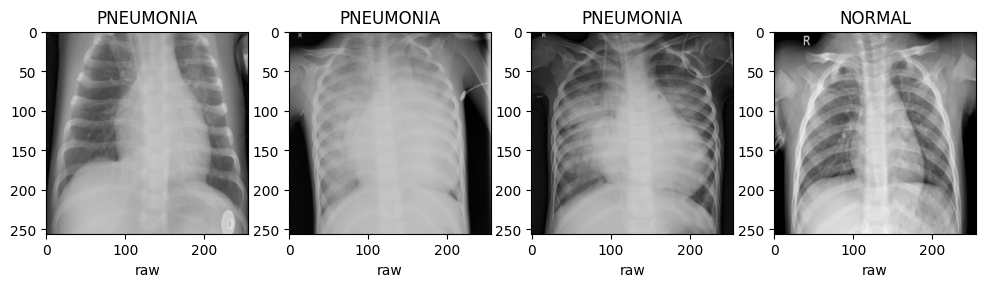

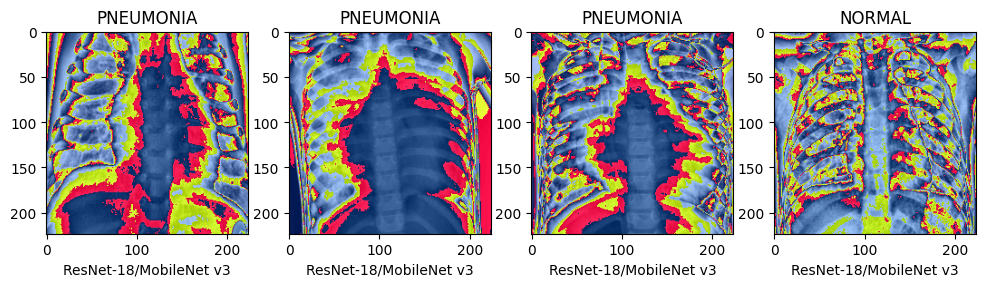

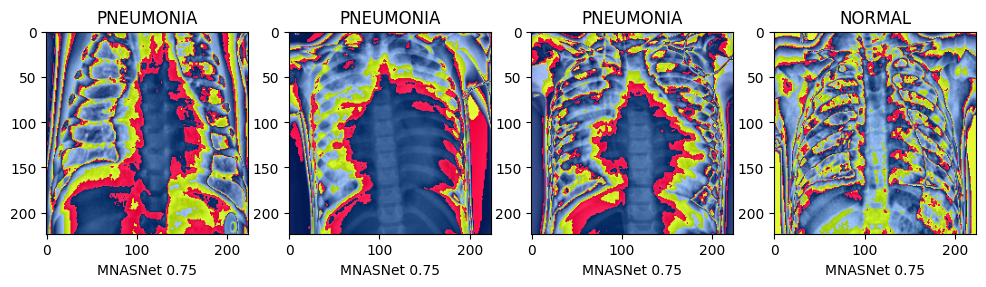

In [4]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure(figsize=(12, 7))
plot_examples("raw", images, labels, classes, transform_crop_and_resize)
plot_examples("ResNet-18/MobileNet v3", images, labels, classes, transform_res_net_18)
plot_examples("MNASNet 0.75", images, labels, classes, transform_mnasnet_0_75)
plt.show()

## 3. Model

### 3.1 ResNet-18

In [5]:
resnet18_model = PneumoniaDetectionResNet18Model()
print(resnet18_model)

PneumoniaDetectionResNet18Model(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

### 3.2 MobileNet v3

In [6]:
mobile_v3_large_model = PneumoniaDetectionMobileNetV3LargeModel()
print(mobile_v3_large_model)

PneumoniaDetectionMobileNetV3LargeModel(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias

### 3.3 MNASNet 0.75

In [7]:
mnasnet_0_75_model = PneumoniaDetectionMNASNet0_75Model()
print(mnasnet_0_75_model)

PneumoniaDetectionMNASNet0_75Model(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): MNASNet(
    (layers): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (8): Sequential(
        (0): _InvertedResidual(
          

## 4. Train

In [8]:
loss_fn = nn.CrossEntropyLoss()

### 4.1 ResNet-18

In [9]:
adam_optimizer = optim.Adam(resnet18_model.parameters(), lr=0.00001)
resnet18_trainer = Trainer(resnet18_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=3)

In [10]:
if allow_restnet18_training:
    resnet18_trainer.fit()

    # save model and training history
    resnet18_model.set_history(resnet18_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({ 
        "state_dict": resnet18_model.state_dict(),
        "history": resnet18_model.history
    }, 
    f"checkpoints/{today}_{resnet18_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(resnet18_model_path)
    resnet18_model.load_state_dict(checkpoint['state_dict'])
    resnet18_model.set_history(checkpoint['history'])

In [11]:
resnet18_model.history

{'train_loss': [0.25013476914685706,
  0.08407243687821471,
  0.048833160831228545],
 'validation_loss': [0.124212984777987,
  0.08702307223342359,
  0.07473771790508181],
 'epochs': 3}

### 4.2 MobileNet v3

In [12]:
adam_optimizer = optim.Adam(mobile_v3_large_model.parameters(), lr=0.00001)
mobile_v3_large_trainer = Trainer(mobile_v3_large_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=8)

In [13]:
if allow_mobile_v3_large_training:
    mobile_v3_large_trainer.fit()

    # save model and training history
    mobile_v3_large_model.set_history(mobile_v3_large_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({
        "state_dict": mobile_v3_large_model.state_dict(),
        "history": mobile_v3_large_model.history
    }, f"checkpoints/{today}_{mobile_v3_large_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(mobile_v3_large_model_path)
    mobile_v3_large_model.load_state_dict(checkpoint["state_dict"])
    mobile_v3_large_model.set_history(checkpoint["history"])

### 4.3 MNASNet 0.75

In [14]:
adam_optimizer = optim.Adam(mnasnet_0_75_model.parameters())
mnasnet_0_75_trainer = Trainer(mnasnet_0_75_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=20)

In [15]:
if allow_mnasnet_0_75_training:
    mnasnet_0_75_trainer.fit()

    # save model and training history
    mnasnet_0_75_model.set_history(mnasnet_0_75_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({
        "state_dict": mnasnet_0_75_model.state_dict(),
        "history": mnasnet_0_75_model.history
    }, f"checkpoints/{today}_{mnasnet_0_75_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(mnasnet_0_75_model_path)
    mnasnet_0_75_model.load_state_dict(checkpoint["state_dict"])
    mnasnet_0_75_model.set_history(checkpoint["history"])

## 5. Evaluation

### 5.1 ResNet-18

[PneumoniaDetectionResNet18Model] Train f1 score: 0.9912616014480591
[PneumoniaDetectionResNet18Model] Validation f1 score: 0.9891719818115234


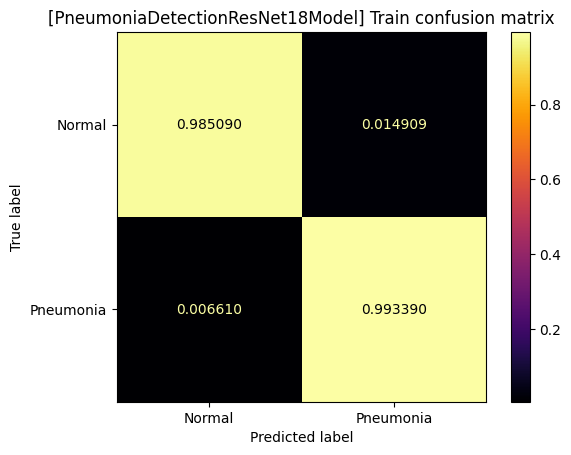

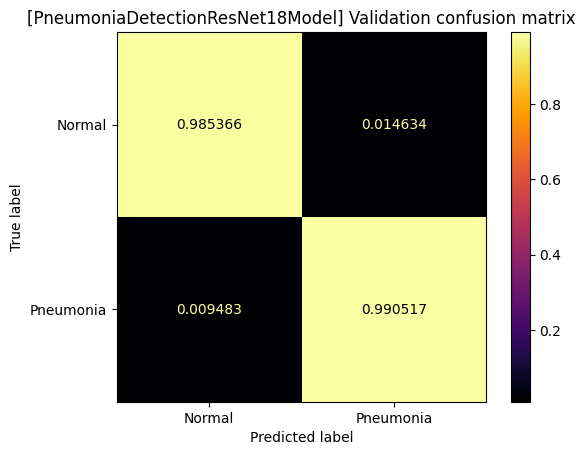

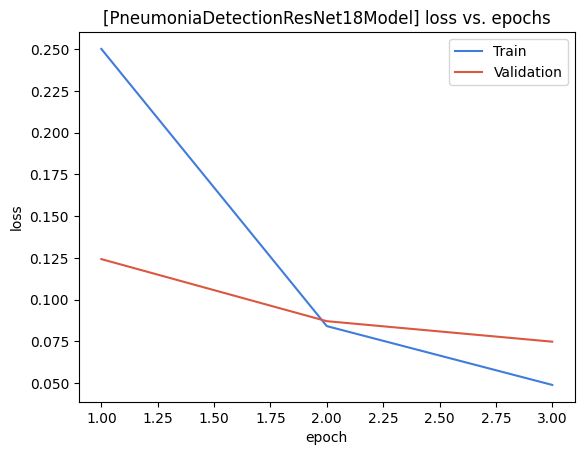

In [16]:
evaluate_training(resnet18_model, train_loader, validation_loader, device=device)
plot_loss(resnet18_model)

### 5.2 MobileNet v3

/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/torch/nn/functional.py:4010: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)


[PneumoniaDetectionMobileNetV3LargeModel] Train f1 score: 0.9871655106544495
[PneumoniaDetectionMobileNetV3LargeModel] Validation f1 score: 0.9840764403343201


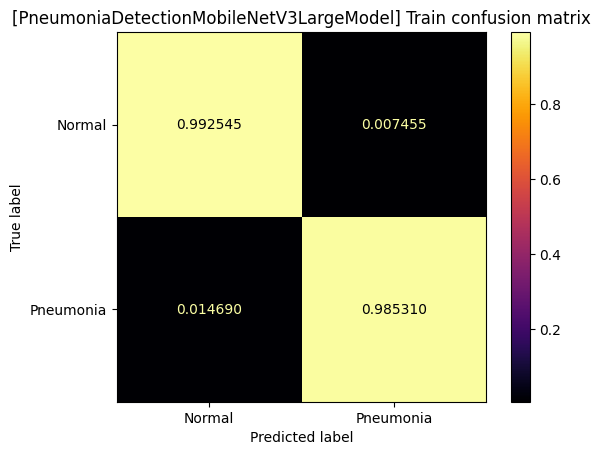

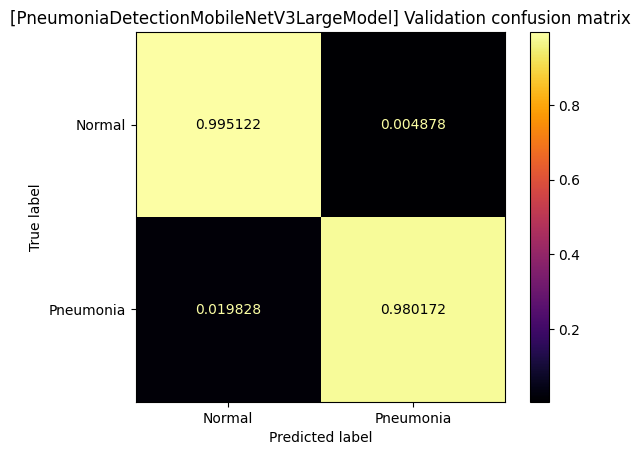

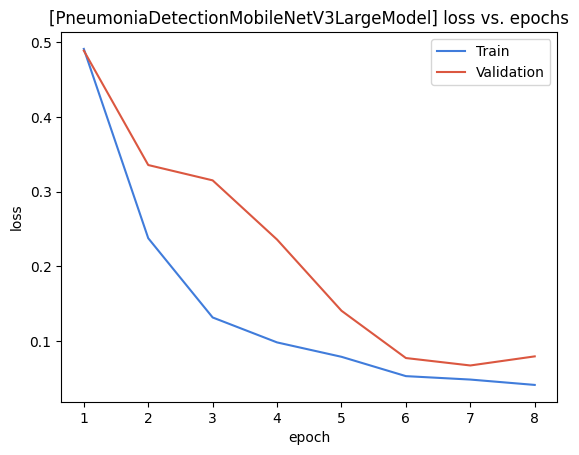

In [17]:
evaluate_training(mobile_v3_large_model, train_loader, validation_loader, device=device)
plot_loss(mobile_v3_large_model)

### 5.3 MNASNet 0.75

[PneumoniaDetectionMNASNet0_75Model] Train f1 score: 0.8148552775382996
[PneumoniaDetectionMNASNet0_75Model] Validation f1 score: 0.8146497011184692


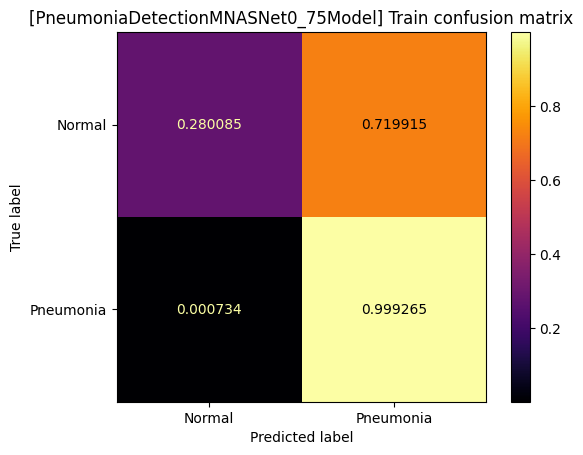

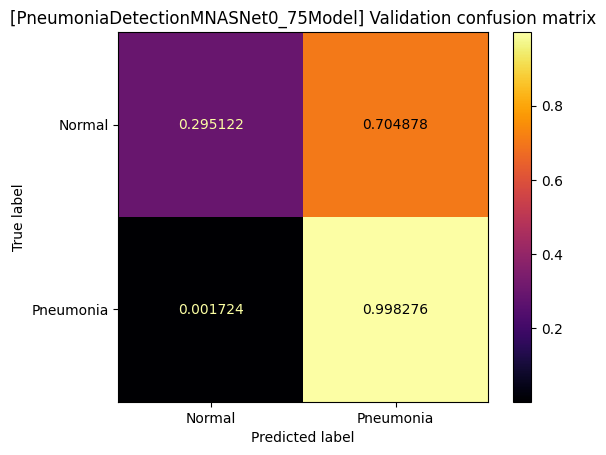

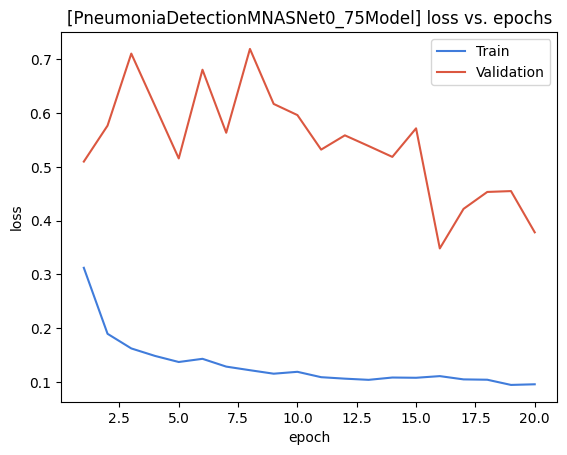

In [18]:
evaluate_training(mnasnet_0_75_model, train_loader, validation_loader, device=device)
plot_loss(mnasnet_0_75_model)

## 6. Test

### 6.1 Guangzhou Women and Children’s Medical Center

[PneumoniaDetectionResNet18Model] Test f1 score: 0.8301282525062561
[PneumoniaDetectionMobileNetV3LargeModel] Test f1 score: 0.8477563858032227
[PneumoniaDetectionMNASNet0_75Model] Test f1 score: 0.6442307829856873


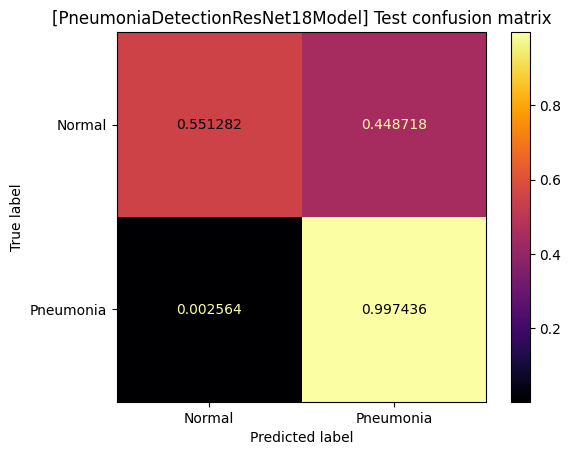

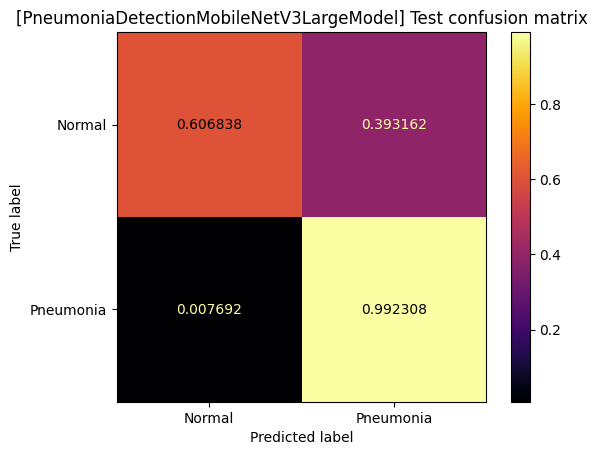

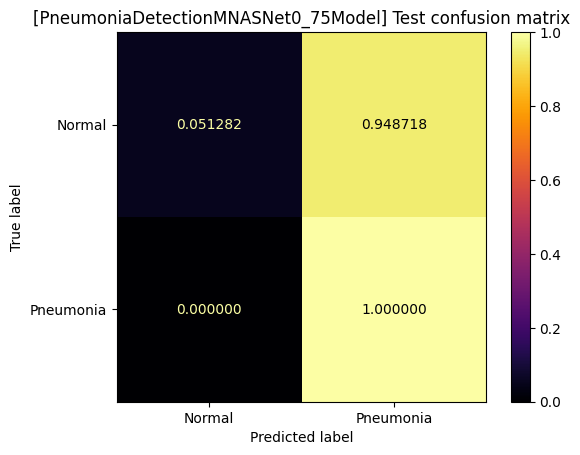

In [19]:
if allow_testing:
    test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
    test_loader = DataLoader(test_set, batch_size=batch_size)

    evaluate_test(resnet18_model, test_loader, device=device)
    evaluate_test(mobile_v3_large_model, test_loader, device=device)
    evaluate_test(mnasnet_0_75_model, test_loader, device=device)

### 6.2 NIH Dataset

[PneumoniaDetectionResNet18Model] Test f1 score: 0.08918970823287964
[PneumoniaDetectionMobileNetV3LargeModel] Test f1 score: 0.13844086229801178
[PneumoniaDetectionMNASNet0_75Model] Test f1 score: 0.07334869354963303


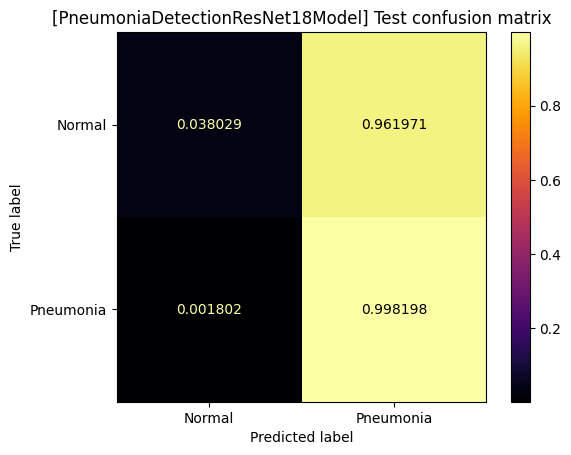

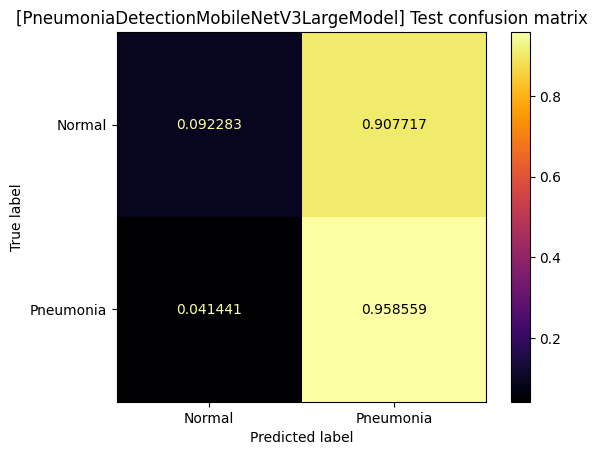

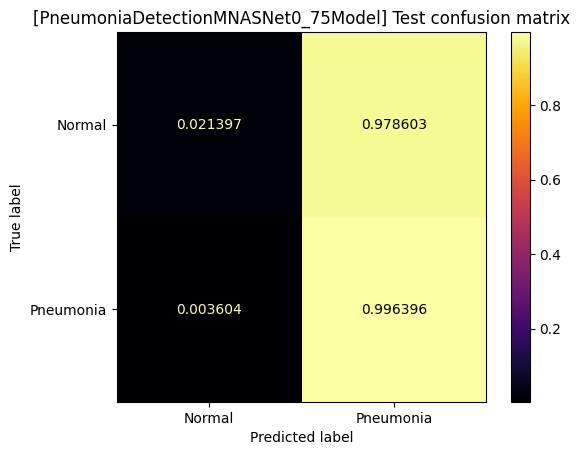

In [20]:
# unbalanced data might be the issue
# analyse images that were wrongly classified to check waht is wrong ("the 1%") 

if allow_testing:
    nih_test_dataset = load_from_disk(nih_test_dataset_path).with_format("torch")
    nih_test_dataset.set_transform(transforms.Compose([transform_3_channels, transform_to_tensor, transform_crop_and_resize]))
    nih_test_dataset_dataloader = DataLoader(nih_test_dataset, batch_size=32, num_workers=4)

    evaluate_test(resnet18_model, nih_test_dataset_dataloader, device=device)
    evaluate_test(mobile_v3_large_model, nih_test_dataset_dataloader, device=device)
    evaluate_test(mnasnet_0_75_model, nih_test_dataset_dataloader, device=device)